In [1]:
#import the libraries
import math
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pickle
import pandas as pd

In [2]:
#MACRO DEF

STOCK = 'GOOG'
EPOCHS = 100
model_path = "machine learning model/"+STOCK+"_model.h5"
error_model_path = "machine learning model/"+STOCK+"_error_model.h5"
error_data = "machine learning model/"+STOCK+"_error_data.csv"
START_DATE = '2012-01-01'
END_DATE = '2022-03-11'
PREDICT_DATE = '2022-03-11'
ERR_EPOCHS = 120

In [3]:
#get the stock data
df = web.DataReader(STOCK, data_source='yahoo' , start=START_DATE , end=END_DATE)

#show the data
df


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,332.827484,324.966949,325.250885,331.462585,7380561.0,331.462585
2012-01-04,333.873566,329.076538,331.273315,332.892242,5749470.0,332.892242
2012-01-05,330.745270,326.889740,329.828735,328.274536,6590410.0,328.274536
2012-01-06,328.767700,323.681763,328.344299,323.796326,5405987.0,323.796326
2012-01-09,322.291962,309.455078,322.042908,310.067780,11688849.0,310.067780
...,...,...,...,...,...,...
2022-03-08,2624.929932,2517.215088,2525.010010,2545.570068,1762500.0,2545.570068
2022-03-09,2683.969971,2601.760010,2628.000000,2677.320068,1612900.0,2677.320068
2022-03-10,2670.770020,2628.020020,2629.250000,2653.639893,1213300.0,2653.639893


In [4]:
#get the number of rows and column in the data set
df.shape

(2566, 6)

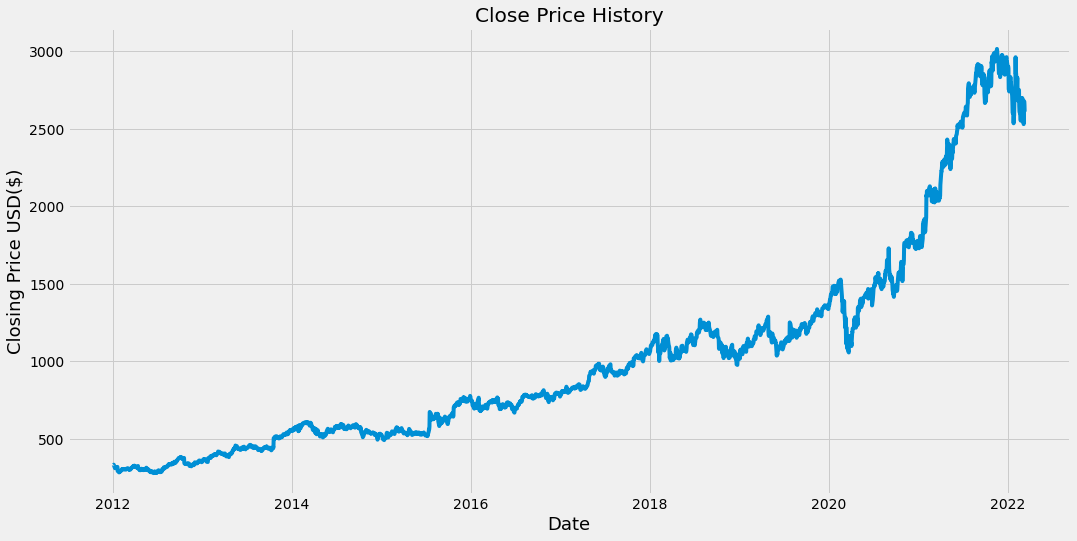

In [5]:
#Visualing the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD($)', fontsize=18)
plt.show()

In [6]:
#Create a new data
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2053

In [7]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01936668],
       [0.01988928],
       [0.01820133],
       ...,
       [0.86820916],
       [0.85207804],
       [0.85207804]])

In [8]:
#creating the training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.01936668, 0.01988928, 0.01820133, 0.01656438, 0.01154608,
       0.01166991, 0.01218339, 0.01285346, 0.01200677, 0.01266046,
       0.01344889, 0.01466159, 0.0049054 , 0.00481982, 0.00398405,
       0.00190099, 0.00164789, 0.00381107, 0.00339409, 0.00383474,
       0.00396584, 0.00474517, 0.00678818, 0.00911159, 0.00868915,
       0.00924999, 0.00954314, 0.00853257, 0.00967788, 0.0092336 ,
       0.00846884, 0.00864364, 0.00830132, 0.01000564, 0.0089022 ,
       0.00856898, 0.00925909, 0.00915165, 0.01080499, 0.0107795 ,
       0.01153516, 0.01132577, 0.01005116, 0.00835958, 0.00869462,
       0.00875653, 0.00750196, 0.00839417, 0.01069393, 0.01036799,
       0.01130391, 0.01201587, 0.01364372, 0.0135545 , 0.01473624,
       0.0158415 , 0.01521149, 0.01643874, 0.01601813, 0.01760956])]
[0.016271218787306516]

[array([0.01936668, 0.01988928, 0.01820133, 0.01656438, 0.01154608,
       0.01166991, 0.01218339, 0.01285346, 0.01200677, 0.01266046,
       0.01344889, 0.01466159, 0.0

In [9]:
#Convert the X_train and Y_train to numpy arrays
x_train , y_train = np.array(x_train), np.array(y_train)

In [10]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1993, 60, 1)

In [11]:
#Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape =(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
#compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
#train the model
model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS)

Epoch 1/100
63/63 [==============================] - 12s 86ms/step - loss: 0.0029
Epoch 2/100
63/63 [==============================] - 11s 170ms/step - loss: 1.9496e-04
Epoch 3/100
63/63 [==============================] - 5s 81ms/step - loss: 1.6834e-04
Epoch 4/100
63/63 [==============================] - 9s 141ms/step - loss: 1.5636e-04
Epoch 5/100
63/63 [==============================] - 10s 163ms/step - loss: 1.6003e-04
Epoch 6/100
63/63 [==============================] - 6s 93ms/step - loss: 1.6497e-04
Epoch 7/100
63/63 [==============================] - 10s 163ms/step - loss: 1.5417e-04
Epoch 8/100
63/63 [==============================] - 10s 157ms/step - loss: 1.5591e-04
Epoch 9/100
63/63 [==============================] - 6s 102ms/step - loss: 1.3696e-04
Epoch 10/100
63/63 [==============================] - 10s 165ms/step - loss: 1.3545e-04
Epoch 11/100
63/63 [==============================] - 10s 161ms/step - loss: 1.4343e-04
Epoch 12/100
63/63 [==============================] 

63/63 [==============================] - 10s 158ms/step - loss: 2.6373e-05
Epoch 95/100
63/63 [==============================] - 10s 155ms/step - loss: 2.9768e-05
Epoch 96/100
63/63 [==============================] - 10s 158ms/step - loss: 2.5236e-05
Epoch 97/100
63/63 [==============================] - 10s 155ms/step - loss: 2.9447e-05
Epoch 98/100
63/63 [==============================] - 10s 154ms/step - loss: 2.7945e-05
Epoch 99/100
63/63 [==============================] - 10s 151ms/step - loss: 2.6744e-05
Epoch 100/100
63/63 [==============================] - 10s 151ms/step - loss: 3.6772e-05


In [14]:
#create the testing data set
#create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#create the data sets x_test adn y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
    


In [15]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
#resahpe the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [17]:
#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
#get the root mean squared error (RMSE)
rmse =  np.sqrt(np.mean(predictions - y_test)**2)
rmse

48.76860822711075

C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


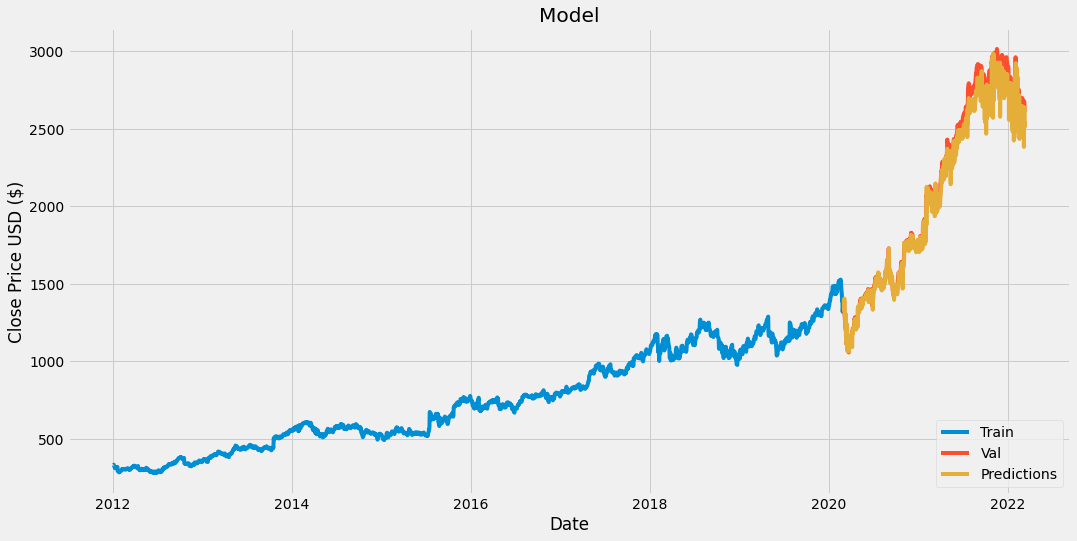

In [19]:
#plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [20]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-03-03,1341.390015,1394.780762
2020-03-04,1386.520020,1330.717896
2020-03-05,1319.040039,1403.983032
2020-03-06,1298.410034,1296.902344
2020-03-09,1215.560059,1306.534790
...,...,...
2022-03-08,2545.570068,2382.274902
2022-03-09,2677.320068,2572.109375
2022-03-10,2653.639893,2637.090088


In [21]:
#get the Quote
stock_quote = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=END_DATE)
#create new data frame
new_df = stock_quote.filter(['Close'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
#create the empty list
x_test = []
#append the past 60 days
x_test.append(last_60_days_scaled)
#convert the x_test data set to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#get the predicted scaled price
pred_price = model.predict(x_test)
#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[2612.3772]]


In [22]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Close'])

Date
2012-01-03     331.462585
2012-01-04     332.892242
2012-01-05     328.274536
2012-01-06     323.796326
2012-01-09     310.067780
                 ...     
2022-03-08    2545.570068
2022-03-09    2677.320068
2022-03-10    2653.639893
2022-03-11    2609.510010
2022-03-11    2609.510010
Name: Close, Length: 2566, dtype: float64


In [23]:
model.save(model_path)
loaded_model = load_model(model_path)



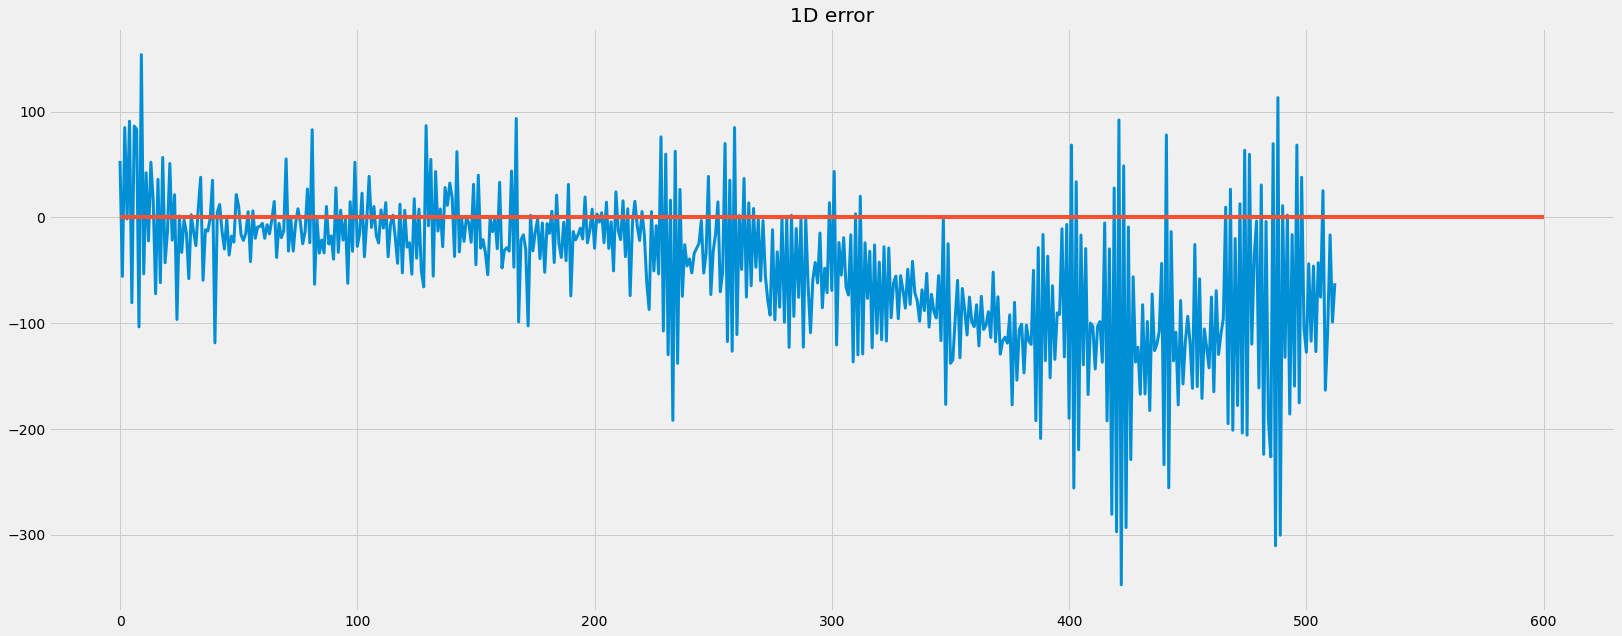

In [24]:
#The Error model
nperr = np.array(predictions - y_test)
nperr.shape
#np.savetxt(error_data,nperr,delimiter=",")
scaled_error = scaler.fit_transform(nperr)
plt.figure(figsize=(25,10))
plt.plot(nperr, linewidth=3)
x = np.linspace(0, 600, 600)
y = np.linspace(0, 0, 600)
plt.plot(x,y)
plt.title("1D error")
plt.show()

In [25]:

nperr.shape
print(type(nperr))
training_errdata_len = math.ceil(len(nperr)*0.8)
training_errdata_len

<class 'numpy.ndarray'>


411

In [26]:
#Scale the error data
errscaler = MinMaxScaler(feature_range=(0,1))
scaled_errdata = errscaler.fit_transform(nperr)


In [27]:
#creating the error training data set
#create the scaled error training data set
train_errdata = scaled_errdata[0:training_errdata_len,:]
#split the data into x_errtrain and y_errtrain data sets
x_errtrain = []
y_errtrain = []
for i in range(60, len(train_errdata)):
    x_errtrain.append(train_errdata[i-60:i,0])
    y_errtrain.append(train_errdata[i,0])
    if i<=61:
        print(x_errtrain)
        print(y_errtrain)
        print()

[array([0.79947047, 0.58161017, 0.86242313, 0.68993777, 0.87445758,
       0.53200253, 0.86511293, 0.85930321, 0.48646343, 1.        ,
       0.58655065, 0.77723552, 0.64856928, 0.79698208, 0.72419694,
       0.54901423, 0.7648506 , 0.56976399, 0.80593096, 0.60742146,
       0.66618281, 0.79457383, 0.6499193 , 0.73571993, 0.5004071 ,
       0.69593575, 0.62685432, 0.68820002, 0.66388464, 0.57746685,
       0.6981309 , 0.66616917, 0.63972635, 0.71077716, 0.76866245,
       0.57436909, 0.66952631, 0.66721572, 0.69116723, 0.76306097,
       0.45637999, 0.70250828, 0.71722401, 0.66697679, 0.63329046,
       0.69104837, 0.62200396, 0.65763555, 0.64641846, 0.73599782,
       0.71381767, 0.66039866, 0.6496207 , 0.66283955, 0.70367758,
       0.60953964, 0.70529039, 0.65362715, 0.67500796, 0.67571548])]
[0.6817010437959814]

[array([0.79947047, 0.58161017, 0.86242313, 0.68993777, 0.87445758,
       0.53200253, 0.86511293, 0.85930321, 0.48646343, 1.        ,
       0.58655065, 0.77723552, 0.648

In [28]:
#Convert the X_errtrain and Y_errtrain to numpy arrays
x_errtrain , y_errtrain = np.array(x_errtrain), np.array(y_errtrain)

In [29]:
#Reshape the error data
x_errtrain = np.reshape(x_errtrain,(x_errtrain.shape[0],x_errtrain.shape[1],1))
x_errtrain.shape

(351, 60, 1)

In [30]:
#Building the LSTM error model
errmodel = Sequential()
errmodel.add(LSTM(50, return_sequences=True, input_shape =(x_errtrain.shape[1],1)))

#adding a fourth fifth layer and some Dropout regularistion
errmodel.add(LSTM(units = 50, return_sequences = False))

errmodel.add(Dense(25))
errmodel.add(Dense(1))

In [31]:
#compile the error Model
errmodel.compile(optimizer='adam', loss='mean_squared_error')


In [32]:
#train the error model
errmodel.fit(x_errtrain, y_errtrain, batch_size=32, epochs=ERR_EPOCHS)

Epoch 1/120
11/11 [==============================] - 4s 74ms/step - loss: 0.1125
Epoch 2/120
11/11 [==============================] - 1s 77ms/step - loss: 0.0158
Epoch 3/120
11/11 [==============================] - 1s 76ms/step - loss: 0.0110
Epoch 4/120
11/11 [==============================] - 1s 77ms/step - loss: 0.0098
Epoch 5/120
11/11 [==============================] - 1s 75ms/step - loss: 0.0092
Epoch 6/120
11/11 [==============================] - 1s 74ms/step - loss: 0.0090
Epoch 7/120
11/11 [==============================] - 1s 73ms/step - loss: 0.0086
Epoch 8/120
11/11 [==============================] - 1s 78ms/step - loss: 0.0085
Epoch 9/120
11/11 [==============================] - 1s 79ms/step - loss: 0.0084
Epoch 10/120
11/11 [==============================] - 1s 74ms/step - loss: 0.0085
Epoch 11/120
11/11 [==============================] - 1s 74ms/step - loss: 0.0087
Epoch 12/120
11/11 [==============================] - 1s 74ms/step - loss: 0.0084
Epoch 13/120
11/11 [=====

11/11 [==============================] - 1s 76ms/step - loss: 0.0083
Epoch 102/120
11/11 [==============================] - 1s 76ms/step - loss: 0.0090
Epoch 103/120
11/11 [==============================] - 1s 75ms/step - loss: 0.0084
Epoch 104/120
11/11 [==============================] - 1s 76ms/step - loss: 0.0079
Epoch 105/120
11/11 [==============================] - 1s 76ms/step - loss: 0.0083
Epoch 106/120
11/11 [==============================] - 1s 77ms/step - loss: 0.0080
Epoch 107/120
11/11 [==============================] - 1s 75ms/step - loss: 0.0078
Epoch 108/120
11/11 [==============================] - 1s 74ms/step - loss: 0.0079
Epoch 109/120
11/11 [==============================] - 1s 73ms/step - loss: 0.0081
Epoch 110/120
11/11 [==============================] - 1s 73ms/step - loss: 0.0079
Epoch 111/120
11/11 [==============================] - 1s 74ms/step - loss: 0.0079
Epoch 112/120
11/11 [==============================] - 1s 78ms/step - loss: 0.0079
Epoch 113/120
11/1

In [33]:
#create the testing error data set
#create a new array containing scaled values 
test_errdata = scaled_errdata[training_errdata_len - 60: , :]
#create the data sets x_errtest adn y_errtest
x_errtest = []
y_errtest = nperr[training_errdata_len:,:]
for i in range(60, len(test_errdata)):
    x_errtest.append(test_errdata[i-60:i,0])


In [34]:
#convert the error data to a numpy array
x_errtest = np.array(x_errtest)



In [35]:
#resahpe the error data
x_errtest = np.reshape(x_errtest,(x_errtest.shape[0],x_errtest.shape[1],1))


In [36]:
#get the models predicted error values
errpredictions = errmodel.predict(x_errtest)
errpredictions = errscaler.inverse_transform(errpredictions)

(102, 1)


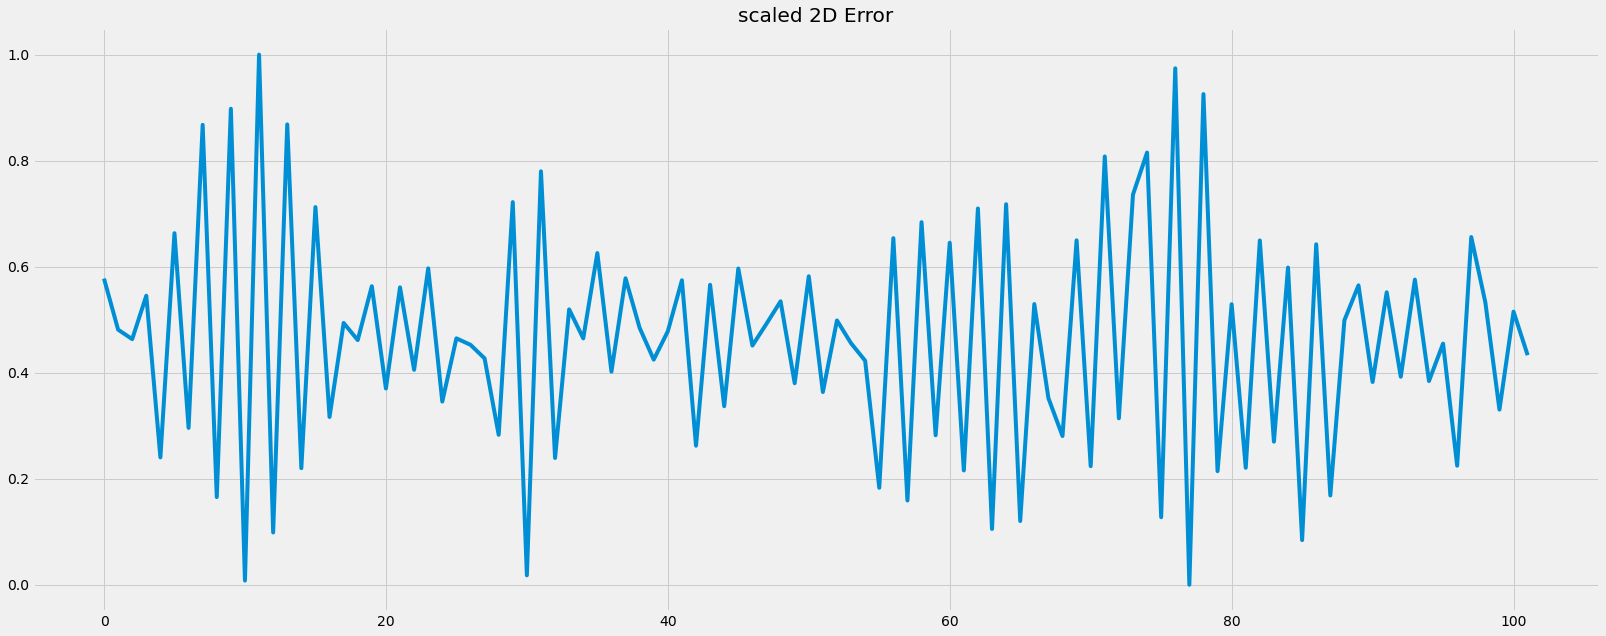

6.242214950860715


In [37]:
#get the root mean squared error (RMSE)
error2d = []
print(errpredictions.shape)
error2d.append(errpredictions - y_errtest)
nperr2d = np.array(errpredictions - y_errtest)
scaled_error2d = errscaler.fit_transform(nperr2d)
#print(nperr)
plt.figure(figsize=(25,10))
plt.plot(scaled_error2d)
plt.title('scaled 2D Error')
plt.show()
rmse2d =  np.sqrt(np.mean(errpredictions - y_errtest)**2)
print(rmse2d)
#print(errpredictions)

(513, 1)
          Error  Error Predictions     Error2d
411 -143.309570         -99.280891   44.028679
412 -103.172119        -101.264488    1.907631
413  -98.505615        -104.415939   -5.910324
414 -136.914062        -107.003448   29.910614
415   -5.271484        -108.715279 -103.443794
..          ...                ...         ...
508 -163.295166         -85.041817   78.253349
509 -105.210693         -80.859604   24.351089
510  -16.549805         -80.580879  -64.031075
511  -98.912842         -82.130272   16.782570
512  -62.230469         -81.359940  -19.129471

[102 rows x 3 columns]


C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


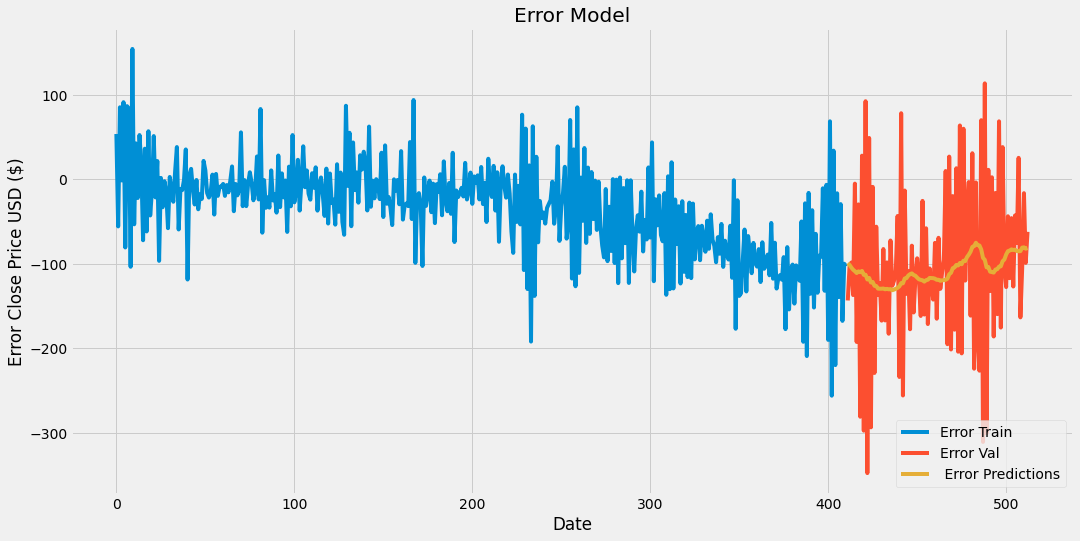

In [38]:
#plot the error data
print(nperr.shape)
dfnperr = pd.DataFrame(nperr, columns = ['Error'])
dfnperr.to_csv(error_data)
errtrain = dfnperr[:training_errdata_len]
errvalid = dfnperr[training_errdata_len:]
errvalid['Error Predictions'] = errpredictions
errvalid['Error2d'] = nperr2d
print(errvalid)
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Error Model')
plt.xlabel('Date')
plt.ylabel('Error Close Price USD ($)')
plt.plot(errtrain['Error'])
plt.plot(errvalid[['Error', 'Error Predictions']])
plt.legend(['Error Train', 'Error Val', ' Error Predictions'], loc='lower right')
plt.show()

In [39]:
#predict the error
last_60_days_error = dfnperr[-60:].values
print(last_60_days_error)

#scale the data to be values between 0 and 1
last_60_days_scaled_error = errscaler.transform(last_60_days_error)


#create the empty list
x_errtest=[]

#append the past 60 days 
x_errtest.append(last_60_days_scaled_error)

#convert the x_test data set to a numpy array
x_errtest = np.array(x_errtest)
x_errtest = np.reshape(x_errtest,(x_errtest.shape[0],x_errtest.shape[1],1))

pred_error = model.predict(x_errtest)

#undo the scaling
pred_error = errscaler.inverse_transform(pred_error)

print(pred_error)

dfnperr.tail()

[[ -25.64355469]
 [-159.95654297]
 [ -58.05151367]
 [-171.16479492]
 [-105.48999023]
 [-123.62402344]
 [-142.26782227]
 [ -75.29248047]
 [-164.86865234]
 [ -69.27368164]
 [-129.59521484]
 [-110.20629883]
 [ -95.61425781]
 [   9.6340332 ]
 [-194.98120117]
 [  26.66064453]
 [-201.22119141]
 [ -19.9934082 ]
 [-177.84277344]
 [  12.89306641]
 [-203.82299805]
 [  63.44384766]
 [-205.83862305]
 [  59.61743164]
 [-119.81469727]
 [ -37.53369141]
 [  -3.38500977]
 [-161.22705078]
 [  30.65429688]
 [-223.9284668 ]
 [  -3.88354492]
 [-191.24365234]
 [-226.29956055]
 [  69.67919922]
 [-310.44799805]
 [ 113.21655273]
 [-300.3737793 ]
 [  11.05712891]
 [-132.20996094]
 [   2.21972656]
 [-185.86499023]
 [ -16.29052734]
 [-159.47265625]
 [  68.34521484]
 [-175.29467773]
 [  37.89550781]
 [-104.54174805]
 [-127.46020508]
 [ -43.83154297]
 [-116.98876953]
 [ -46.02856445]
 [-126.83666992]
 [ -42.81811523]
 [ -75.33911133]
 [  25.21850586]
 [-163.29516602]
 [-105.21069336]
 [ -16.54980469]
 [ -98.9128418

,Error
508,-163.295166
509,-105.210693
510,-16.549805
511,-98.912842
512,-62.230469


In [40]:
print("the predicted value with 1D error correction ")
print(pred_price[0][0]-pred_error[0][0])

the predicted value with 1D error correction 
2668.208


In [41]:
model.save(error_model_path)
loaded_model = load_model(error_model_path)


In [42]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Close'])

Date
2012-01-03     331.462585
2012-01-04     332.892242
2012-01-05     328.274536
2012-01-06     323.796326
2012-01-09     310.067780
                 ...     
2022-03-08    2545.570068
2022-03-09    2677.320068
2022-03-10    2653.639893
2022-03-11    2609.510010
2022-03-11    2609.510010
Name: Close, Length: 2566, dtype: float64


In [43]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)